![](images/2025-08-27-squeezenet-implementation.png)

## Introduction

In our [previous post](https://hassaanbinaslam.github.io/myblog/posts/2025-08-21-squeezenet-reading-notes.html), we took a deep dive into the theory behind the landmark SqueezeNet paper. We deconstructed the "why"—the motivations and the brilliant design strategies that allowed researchers to achieve AlexNet-level performance with a model over 500 times smaller.

Now, it's time to get our hands dirty and build the "how."

Reading a paper is one thing, but true understanding often comes from implementation. The goal of this post is to translate the concepts from the SqueezeNet paper into a complete, working PyTorch model. We'll walk through the code step-by-step, build the architecture from the ground up, train it on a real dataset, and analyze the results to see if we can replicate the incredible efficiency that made SqueezeNet famous.

::: {.callout-tip}
The complete Jupyter Notebook for this post is available on GitHub. You can view it, download it, and run the code yourself at the following link:

[2025-08-27-squeezenet-implementation.ipynb](https://github.com/hassaanbinaslam/myblog/blob/main/posts/2025-08-27-squeezenet-implementation.ipynb)


**Where to run this notebook?**

I ran this notebook on an **AWS SageMaker Notebook Instance** with the instance type `ml.g4dn.xlarge` and platform identifier **Amazon Linux 2, JupyterLab 4**. The `g4dn.xlarge` instance belongs to the GPU family and comes with **4 vCPUs, 16 GiB of memory, and 1 NVIDIA T4 Tensor Core GPU**.

Alternatively, you can use **Google Colab**, which provides free access to the same type of GPU and is an excellent platform for running Jupyter notebooks. I tested the notebook on Colab with the free-tier T4 GPU, and it worked seamlessly. The training loop takes around **1.5 hours** to complete on Colab.

In my experience, training completes faster on the `g4dn.xlarge` instance compared to Colab.
:::

### Our Training Ground: The CIFAR-10 Dataset

The original SqueezeNet was trained on the massive ImageNet dataset, which contains over a million images across 1000 categories. Training on ImageNet from scratch requires immense computational resources and time.

For this post, we'll use the popular **CIFAR-10** dataset. It consists of 60,000 `32x32` color images in 10 classes, such as 'plane', 'car', 'bird', and 'dog'. CIFAR-10 is a fantastic learning tool because it's complex enough to be a meaningful challenge, but small enough that we can train our network in a reasonable amount of time on a single GPU. It's the perfect environment to validate our SqueezeNet implementation.

### Our Roadmap for this Post

We will follow the logical flow of a machine learning project, from data preparation to final analysis. Here’s what we’ll cover:

1.  **Setting the Stage:** We'll begin by setting up our environment, importing the necessary libraries, and creating our data loaders with powerful augmentations to help our model generalize.
2.  **Building the `Fire` Module:** We'll implement the heart of SqueezeNet, the `Fire` module, as a custom `nn.Module` in PyTorch.
3.  **Assembling the Full `SqueezeNet`:** Using our `Fire` module as a building block, we'll construct the complete SqueezeNet macroarchitecture.
4.  **Training and Analysis:** We'll write a complete training loop, train the model on CIFAR-10, and visualize its performance with detailed plots.
5.  **The Final Verdict:** Finally, we'll calculate our trained model's parameter count and file size to see how it stacks up against the paper's promise of extreme efficiency.

Let's dive in and start writing some code!

## Setting the Stage - Data, Augmentation, and Optimization

Before we can build our network, we need to prepare our data. A robust and efficient data pipeline is the foundation of any successful deep learning project. In this section, we'll handle three key steps: setting up our environment, defining our data transformations (including augmentation), and creating optimized data loaders to feed the GPU.

### Step 1: Environment and Imports

First, we'll import all the necessary libraries. We're using PyTorch for building and training the model, Matplotlib for plotting, and a few other helpful utilities. For reproducibility, it's great practice to log the versions of our key libraries using `watermark`. This helps ensure that others (or our future selves!) can recreate the same environment.

In [1]:
%%capture
!pip install watermark

In [2]:
%load_ext watermark

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import os
import matplotlib.pyplot as plt
import numpy as np

from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

%matplotlib inline

In [4]:
%watermark -v -m -p torch,torchvision,matplotlib,watermark,tqdm

Python implementation: CPython
Python version       : 3.10.18
IPython version      : 8.37.0

torch      : 2.6.0+cu124
torchvision: 0.21.0+cu124
matplotlib : 3.10.5
watermark  : 2.5.0
tqdm       : 4.67.1

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 5.10.240-238.959.amzn2.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



### Step 2: Data Augmentation and Transformation

Raw image data is rarely fed directly into a neural network. We need to process it first. We'll define two separate transformation pipelines: one for our training data and one for our validation/testing data.

**For Training Data:**

Our `train_transform` is a sequence of operations designed to prepare the data and also to *augment* it. Data augmentation is a powerful technique to artificially increase the diversity of your training set and prevent the model from overfitting.

```python
# For training: resize, augment, convert to tensor, normalize
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
```

Let's break down what each step does:

*   `transforms.Resize(224)`: The original SqueezeNet was designed for 224x224 pixel images from ImageNet. We resize our smaller 32x32 CIFAR-10 images to match this expected input size.
*   `transforms.RandomHorizontalFlip()`: This randomly flips half of the images horizontally. This teaches the model that a car facing left is still a car, making it more robust.
*   `transforms.RandomRotation(10)`: This randomly rotates images by a small amount (up to 10 degrees). This helps the model become invariant to slight changes in orientation.
*   `transforms.ToTensor()`: This converts the image from a PIL Image format into a PyTorch tensor, the fundamental data structure used by the framework.
*   `transforms.Normalize(...)`: This standardizes the pixel values of the tensor. By normalizing them to have a mean of 0.5 and a standard deviation of 0.5, we ensure the data is in a range that's ideal for the network to learn from, which can lead to faster and more stable training.

**For Validation/Testing Data:**

Our `test_transform` is simpler. We perform the necessary resizing, conversion to a tensor, and normalization, but we **do not** use augmentation. We want to evaluate our model on the clean, original test data, not modified versions of it.

```python
# For validation/testing: just resize, convert to tensor, normalize
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
```

### Step 3: Creating Optimized DataLoaders

Now that we have our transformation pipelines, we'll create PyTorch `DataLoaders`. A DataLoader is a powerful utility that automatically handles batching our data, shuffling it, and loading it in parallel.

We'll pay attention to a few key parameters to make our data pipeline as fast as possible:

*   `batch_size = 128`: We'll process the data in batches of 128 images. This is more efficient for the GPU than processing images one by one.
*   `num_workers`: This tells the DataLoader to use multiple subprocesses to load data in the background. A good starting point is the number of CPU cores you have. This prevents the CPU from becoming a bottleneck while the GPU waits for data.
*   `pin_memory=True`: This is a great optimization. It tells PyTorch to place the data tensors in a special "pinned" memory region, which allows for much faster, non-blocking data transfer from the CPU to the GPU.

In [ ]:
# --- Data Loading and Augmentation ---
# For training: resize, augment, convert to tensor, normalize
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# For validation/testing: just resize, convert to tensor, normalize
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# --- Data Loader Optimizations ---
# Increased batch size for better GPU utilization
batch_size = 128
# Use more workers to load data in parallel
# Use os.cpu_count() for a good starting point, but you may need to tune this
num_workers = min(os.cpu_count(), 8)
print("num_workers: ", num_workers)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
# Enabled pin_memory=True for faster CPU to GPU data transfer
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_workers:  4


### Step 4: Final Sanity Check - Let's See the Data!

Before we move on to building our model, it's always a good idea to perform a quick sanity check to make sure our data pipeline is working as expected. Let's grab one batch of images from our `trainloader` and display them with their correct labels.

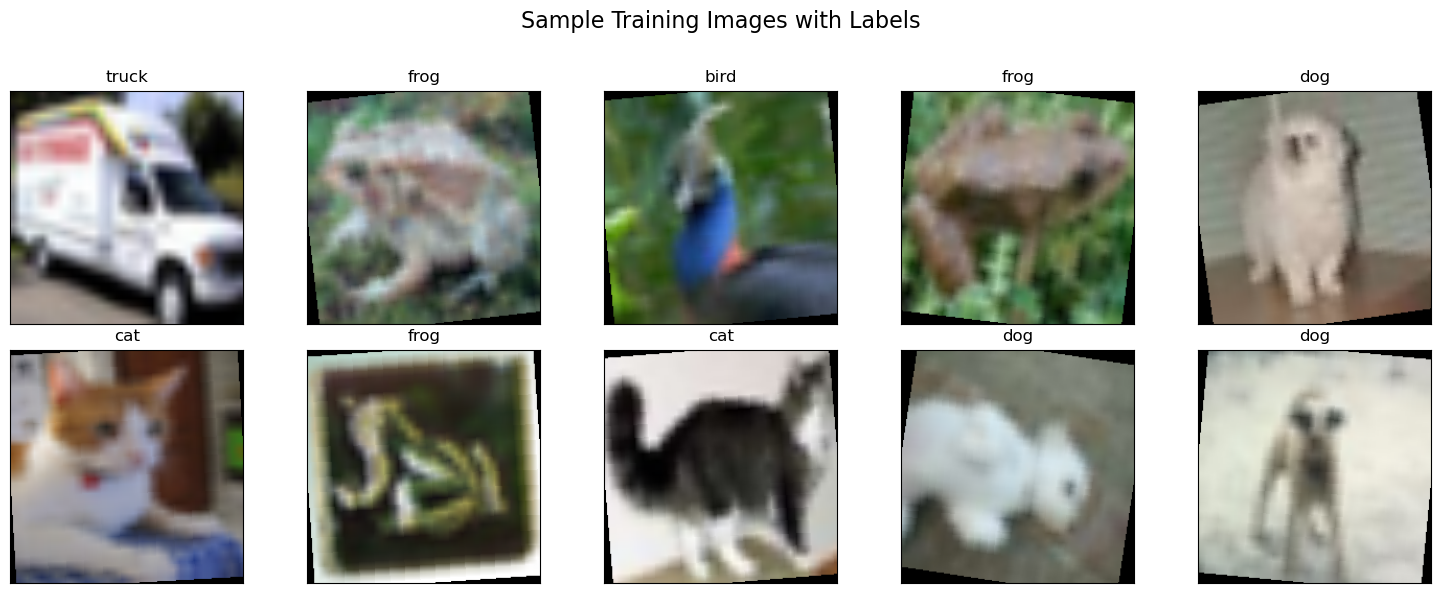

In [ ]:
# --- Get a batch of training data ---
# Create an iterator from the dataloader
dataiter = iter(trainloader)
# Get the first batch of images and labels
images, labels = next(dataiter)

# --- Define a function to display an image ---
# This function will un-normalize and display a single image tensor
def imshow(img):
    img = img / 2 + 0.5     # Un-normalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Convert from Tensor image

# --- Create a grid of images and display them ---
# Number of images to display
num_images_to_show = 10

# Create a figure with a grid of subplots
# We'll use 2 rows and 5 columns to display 10 images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

# Flatten the axes array to make it easy to loop over
axes = axes.flatten()

for i in range(num_images_to_show):
    ax = axes[i]

    # Detach the image tensor, move to CPU, and un-normalize
    img = images[i].cpu()
    img = img / 2 + 0.5  # Un-normalize
    npimg = img.numpy()

    # Display the image
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

    # Set the title of the subplot to the corresponding class label
    ax.set_title(classes[labels[i]])

    # Remove the x and y axis ticks for a cleaner look
    ax.set_xticks([])
    ax.set_yticks([])

# Add a title for the entire figure and adjust layout
plt.suptitle('Sample Training Images with Labels', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

## Implementing the `Fire` Module in PyTorch

With our data pipeline ready, it's time to build the engine of SqueezeNet: the `Fire` module. As we learned in our theory deep-dive, this compact and efficient module is the key to SqueezeNet's small size and high performance.

We'll implement the `Fire` module as a custom class that inherits from PyTorch's `nn.Module`. This allows us to define its constituent layers in the `__init__` method and specify how data flows through them in the `forward` method.

### The Code: `Fire` Module

Here is the complete PyTorch implementation of the Fire module:

In [ ]:
class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        
        # Squeeze Layer
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        
        # Expand Layer - 1x1 branch
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)

        # Expand Layer - 3x3 branch
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Squeeze the input
        x = self.squeeze_activation(self.squeeze(x))
        
        # Pass through both expand branches and concatenate the results
        return torch.cat(
            [self.expand1x1_activation(self.expand1x1(x)), self.expand3x3_activation(self.expand3x3(x))], 1
        )

#### Code Breakdown

Let's walk through this code to see how it perfectly mirrors the paper's design.

**The `__init__` Method (The Blueprint):**

This is where we define all the layers our module will use.

*   `self.squeeze`: This is our bottleneck layer, a simple `nn.Conv2d` with a `kernel_size=1`. Its purpose is to take the input (`inplanes`) and reduce its channel dimension down to `squeeze_planes`.
*   `self.expand1x1`: This is the 1x1 branch of the expand layer. It takes the squeezed feature map and applies `expand1x1_planes` number of 1x1 filters.
*   `self.expand3x3`: This is the 3x3 branch. It *also* takes the squeezed feature map and applies `expand3x3_planes` number of 3x3 filters.
    *   **Crucial Detail:** Notice the `padding=1` argument. A 3x3 convolution would normally shrink the feature map's height and width. This padding ensures the output of the 3x3 branch has the exact same spatial dimensions as the output of the 1x1 branch, which is essential for the next step.
*   `ReLU(inplace=True)`: We use the standard ReLU activation function after each convolution. `inplace=True` is a small memory optimization.

**The `forward` Method (The Assembly Line):**

This method defines how data flows through the layers we just created.

1.  First, the input tensor `x` is passed through the squeeze convolution and its activation function. This creates our thin, bottlenecked feature map.
2.  Next, this single squeezed tensor is fed into *both* the `expand1x1` and `expand3x3` branches in parallel.
3.  Finally, the magic happens with `torch.cat([...], 1)`. We take the outputs of the two expand branches and concatenate them along **dimension 1** (the channel dimension). This stacks the feature maps from both branches together, creating the final, wider output of the Fire module.

This clean and modular implementation gives us the reusable building block we need to construct the full SqueezeNet architecture.

## Assembling the Full `SqueezeNet` Model

Now that we have our `Fire` module "LEGO brick," we can stack them together to build the complete SqueezeNet macroarchitecture, just as described in [Table 1 of the paper](https://hassaanbinaslam.github.io/myblog/posts/2025-08-21-squeezenet-reading-notes.html#the-results---proof-in-the-numbers).

In [ ]:
class SqueezeNet(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.5) -> None:
        super().__init__()
        self.num_classes = num_classes

        # Feature extractor, following the paper's architecture
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(96, 16, 64, 64),
            Fire(128, 16, 64, 64),
            Fire(128, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(256, 32, 128, 128),
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(512, 64, 256, 256),
        )

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

### Code Breakdown

*   **`self.features`**: We use the convenient `nn.Sequential` to define the main body of the network. You can literally trace the layers in this code and match them to the architecture in the paper's Table 1. Notice the `MaxPool2d` layers are spaced out, perfectly implementing **Strategy #3 (Late Downsampling)**. The numbers inside each `Fire(...)` call correspond exactly to the `inplanes`, `squeeze_planes`, and `expand_planes` for that stage of the network.
*   **`self.classifier`**: This is our modern, efficient classifier.
    *   `nn.Dropout`: A standard regularization technique to prevent overfitting.
    *   `final_conv`: A simple `nn.Conv2d` with a 1x1 kernel that maps the 512 channels from the feature extractor down to the final `num_classes` (10 for CIFAR-10).
    *   `nn.AdaptiveAvgPool2d((1, 1))`: This is PyTorch's implementation of Global Average Pooling. It takes the feature maps from the final convolution, no matter their height and width, and averages them down to a `1x1` size. This is what allows us to avoid the bulky, parameter-heavy `Linear` layers used in older models.
*   **`forward` method**: The data flow is beautifully simple. The input `x` goes through the `features` block, then the `classifier` block. The final `torch.flatten(x, 1)` converts the output from a `(batch_size, num_classes, 1, 1)` tensor into the standard `(batch_size, num_classes)` shape expected by the loss function.

With just these two classes, we have a complete implementation of the entire SqueezeNet architecture. Now, let's train it!

## Training SqueezeNet and Analyzing the Results

We have our data pipeline and our model architecture. Now, let's put them together and train our SqueezeNet model on the CIFAR-10 dataset. We'll set up a robust training loop and then analyze the output to understand how our model learned over time.

### Step 1: The Training Setup

Before we start the main loop, we need to define a few key components for training:

*   **Device:** We'll automatically detect if a CUDA-enabled GPU is available and use it; otherwise, we'll fall back to the CPU. Training on a GPU is dramatically faster.
*   **Optimizer:** We'll use `AdamW`, a popular and effective optimizer that often converges faster than standard SGD.
*   **Loss Function:** Since this is a multi-class classification problem, `nn.CrossEntropyLoss` is the standard choice.
*   **Learning Rate Scheduler:** We'll use `ReduceLROnPlateau`. This is a smart scheduler that monitors the validation loss. If the loss stops improving for a set number of epochs (a "patience" of 2 in our case), it will automatically reduce the learning rate. This helps the model fine-tune its weights in the later stages of training.
*   **Early Stopping:** To save time and prevent overfitting, we'll implement early stopping. We'll monitor the validation loss at the end of each epoch and save a copy of the model only when it achieves a new "best" (lowest) validation loss.

In [ ]:
# --- Model, Optimizer, and Training Setup ---
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

net = SqueezeNet() # initialize your model
net.to(device)

# --- Compile the model (PyTorch 2.0+ feature) ---
# This is a massive speedup!
if torch.__version__[0] == '2':
    print("PyTorch 2.0+ detected. Compiling the model...")
    net = torch.compile(net)

Using device: cuda:0
PyTorch 2.0+ detected. Compiling the model...


In [ ]:
criterion = nn.CrossEntropyLoss()
# Using a potentially faster-converging optimizer
optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 40

In [ ]:
# --- DEFINE THE ReduceLROnPlateau SCHEDULER ---
# This scheduler monitors the validation loss.
# 'patience=2': Wait for 2 epochs of no improvement before reducing LR.
# 'factor=0.1': Reduce LR by a factor of 10 (e.g., 0.001 -> 0.0001).
# 'mode=min': It's monitoring a value that should be minimized (loss).
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

In [ ]:
# --- EARLY STOPPING SETUP ---
# Path to save the best model
SAVE_PATH = 'best_model.pth'
# Initialize variables to track the best performance
best_val_loss = float('inf')
best_epoch = 0

In [13]:
# --- History Tracking ---
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'learning_rate': [] # Let's also track the learning rate to plot it!
}

### Step 2: The Training Loop and Output

Our training loop runs for a total of 40 epochs. In each epoch, it performs a full pass over the training data to update the model's weights, followed by a full pass over the validation data to check its performance on unseen images.

In [ ]:
print("Starting Training...")
for epoch in range(num_epochs):
    # --- Training Phase ---
    net.train()
    
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    current_lr = optimizer.param_groups[0]['lr']
    train_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training] LR: {current_lr:.6f}")

    for data in train_bar:
        inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)
    history['learning_rate'].append(current_lr)

    # --- Validation Phase ---
    net.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_bar = tqdm(testloader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
    with torch.no_grad():
        for data in val_bar:
            inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_bar.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(testloader)
    val_accuracy = 100 * correct_val / total_val
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    # --- EARLY STOPPING LOGIC ---
    # Check if the current validation loss is the best we've seen so far.
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        # Save the model's state dictionary
        torch.save(net._orig_mod.state_dict(), SAVE_PATH)
        print(f"\n---> New best model saved at epoch {best_epoch} with validation loss: {best_val_loss:.4f}\n")

    scheduler.step(avg_val_loss)

    print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    print(f"  Valid Loss: {avg_val_loss:.4f} | Valid Acc: {val_accuracy:.2f}%")
    print(f"  Current LR: {optimizer.param_groups[0]['lr']:.6f}\n")

print('Finished Training')
print(f"The best model was saved from epoch {best_epoch} at path: {SAVE_PATH}")

Starting Training...


Epoch 1/40 [Validation]: 100%|██████████| 79/79 [00:10<00:00,  7.34it/s, loss=1.75]



---> New best model saved at epoch 1 with validation loss: 1.8390


Epoch 1/40 Summary:
  Train Loss: 2.0931 | Train Acc: 21.73%
  Valid Loss: 1.8390 | Valid Acc: 31.86%
  Current LR: 0.001000



Epoch 2/40 [Validation]: 100%|██████████| 79/79 [00:08<00:00,  8.80it/s, loss=1.72]



---> New best model saved at epoch 2 with validation loss: 1.6319


Epoch 2/40 Summary:
  Train Loss: 1.7570 | Train Acc: 36.83%
  Valid Loss: 1.6319 | Valid Acc: 41.62%
  Current LR: 0.001000



Epoch 3/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.70it/s, loss=1.76]



---> New best model saved at epoch 3 with validation loss: 1.5504


Epoch 3/40 Summary:
  Train Loss: 1.5792 | Train Acc: 45.08%
  Valid Loss: 1.5504 | Valid Acc: 46.14%
  Current LR: 0.001000



Epoch 4/40 [Validation]: 100%|██████████| 79/79 [00:08<00:00,  8.81it/s, loss=1.59] 



---> New best model saved at epoch 4 with validation loss: 1.1688


Epoch 4/40 Summary:
  Train Loss: 1.3565 | Train Acc: 52.19%
  Valid Loss: 1.1688 | Valid Acc: 58.67%
  Current LR: 0.001000



Epoch 5/40 [Validation]: 100%|██████████| 79/79 [00:08<00:00,  8.78it/s, loss=1.56] 



---> New best model saved at epoch 5 with validation loss: 1.1274


Epoch 5/40 Summary:
  Train Loss: 1.1526 | Train Acc: 58.94%
  Valid Loss: 1.1274 | Valid Acc: 61.63%
  Current LR: 0.001000



Epoch 6/40 [Validation]: 100%|██████████| 79/79 [00:08<00:00,  8.79it/s, loss=1.23] 



---> New best model saved at epoch 6 with validation loss: 0.9898


Epoch 6/40 Summary:
  Train Loss: 1.0576 | Train Acc: 62.63%
  Valid Loss: 0.9898 | Valid Acc: 65.36%
  Current LR: 0.001000



Epoch 7/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.71it/s, loss=1.07] 



---> New best model saved at epoch 7 with validation loss: 0.9031


Epoch 7/40 Summary:
  Train Loss: 0.9776 | Train Acc: 65.39%
  Valid Loss: 0.9031 | Valid Acc: 68.49%
  Current LR: 0.001000



Epoch 8/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.74it/s, loss=1.17] 



---> New best model saved at epoch 8 with validation loss: 0.8737


Epoch 8/40 Summary:
  Train Loss: 0.9200 | Train Acc: 67.50%
  Valid Loss: 0.8737 | Valid Acc: 69.74%
  Current LR: 0.001000



Epoch 9/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.65it/s, loss=1.17] 



---> New best model saved at epoch 9 with validation loss: 0.8723


Epoch 9/40 Summary:
  Train Loss: 0.8787 | Train Acc: 69.02%
  Valid Loss: 0.8723 | Valid Acc: 69.43%
  Current LR: 0.001000



Epoch 10/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.60it/s, loss=1.01] 



Epoch 10/40 Summary:
  Train Loss: 0.8413 | Train Acc: 70.54%
  Valid Loss: 0.9084 | Valid Acc: 68.65%
  Current LR: 0.001000



Epoch 11/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.58it/s, loss=0.941]



---> New best model saved at epoch 11 with validation loss: 0.8162


Epoch 11/40 Summary:
  Train Loss: 0.8002 | Train Acc: 71.84%
  Valid Loss: 0.8162 | Valid Acc: 71.49%
  Current LR: 0.001000



Epoch 12/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.68it/s, loss=1.09] 



---> New best model saved at epoch 12 with validation loss: 0.7833


Epoch 12/40 Summary:
  Train Loss: 0.7779 | Train Acc: 72.71%
  Valid Loss: 0.7833 | Valid Acc: 72.92%
  Current LR: 0.001000



Epoch 13/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.73it/s, loss=0.779]



Epoch 13/40 Summary:
  Train Loss: 0.7426 | Train Acc: 73.95%
  Valid Loss: 0.7906 | Valid Acc: 73.53%
  Current LR: 0.001000



Epoch 14/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.64it/s, loss=0.651]



---> New best model saved at epoch 14 with validation loss: 0.7424


Epoch 14/40 Summary:
  Train Loss: 0.7237 | Train Acc: 74.84%
  Valid Loss: 0.7424 | Valid Acc: 74.53%
  Current LR: 0.001000



Epoch 15/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.68it/s, loss=0.989]



---> New best model saved at epoch 15 with validation loss: 0.6920


Epoch 15/40 Summary:
  Train Loss: 0.7021 | Train Acc: 75.52%
  Valid Loss: 0.6920 | Valid Acc: 76.06%
  Current LR: 0.001000



Epoch 16/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.68it/s, loss=0.713]



---> New best model saved at epoch 16 with validation loss: 0.6897


Epoch 16/40 Summary:
  Train Loss: 0.6817 | Train Acc: 76.48%
  Valid Loss: 0.6897 | Valid Acc: 76.15%
  Current LR: 0.001000



Epoch 17/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.66it/s, loss=0.491]



---> New best model saved at epoch 17 with validation loss: 0.6855


Epoch 17/40 Summary:
  Train Loss: 0.6645 | Train Acc: 76.98%
  Valid Loss: 0.6855 | Valid Acc: 76.53%
  Current LR: 0.001000



Epoch 18/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.63it/s, loss=0.584]



Epoch 18/40 Summary:
  Train Loss: 0.6430 | Train Acc: 77.51%
  Valid Loss: 0.6882 | Valid Acc: 76.71%
  Current LR: 0.001000



Epoch 19/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.51it/s, loss=0.602]



---> New best model saved at epoch 19 with validation loss: 0.6528


Epoch 19/40 Summary:
  Train Loss: 0.6260 | Train Acc: 78.59%
  Valid Loss: 0.6528 | Valid Acc: 77.44%
  Current LR: 0.001000



Epoch 20/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.63it/s, loss=0.985]



Epoch 20/40 Summary:
  Train Loss: 0.6112 | Train Acc: 78.84%
  Valid Loss: 0.6556 | Valid Acc: 78.34%
  Current LR: 0.001000



Epoch 21/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.66it/s, loss=0.469]



---> New best model saved at epoch 21 with validation loss: 0.6311


Epoch 21/40 Summary:
  Train Loss: 0.6036 | Train Acc: 79.25%
  Valid Loss: 0.6311 | Valid Acc: 77.80%
  Current LR: 0.001000



Epoch 22/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.60it/s, loss=0.933]



---> New best model saved at epoch 22 with validation loss: 0.6292


Epoch 22/40 Summary:
  Train Loss: 0.5879 | Train Acc: 79.67%
  Valid Loss: 0.6292 | Valid Acc: 78.66%
  Current LR: 0.001000



Epoch 23/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.60it/s, loss=0.809]



Epoch 23/40 Summary:
  Train Loss: 0.5719 | Train Acc: 80.13%
  Valid Loss: 0.6631 | Valid Acc: 78.27%
  Current LR: 0.001000



Epoch 24/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.59it/s, loss=0.523]



Epoch 24/40 Summary:
  Train Loss: 0.5611 | Train Acc: 80.51%
  Valid Loss: 0.6358 | Valid Acc: 78.58%
  Current LR: 0.001000



Epoch 25/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.69it/s, loss=0.522]



---> New best model saved at epoch 25 with validation loss: 0.6080


Epoch 25/40 Summary:
  Train Loss: 0.5564 | Train Acc: 80.69%
  Valid Loss: 0.6080 | Valid Acc: 79.01%
  Current LR: 0.001000



Epoch 26/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.62it/s, loss=0.701]



Epoch 26/40 Summary:
  Train Loss: 0.5376 | Train Acc: 81.27%
  Valid Loss: 0.6286 | Valid Acc: 79.54%
  Current LR: 0.001000



Epoch 27/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.60it/s, loss=0.558]



Epoch 27/40 Summary:
  Train Loss: 0.5353 | Train Acc: 81.31%
  Valid Loss: 0.6098 | Valid Acc: 79.64%
  Current LR: 0.001000



Epoch 28/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.44it/s, loss=0.325]



---> New best model saved at epoch 28 with validation loss: 0.5744


Epoch 28/40 Summary:
  Train Loss: 0.5299 | Train Acc: 81.55%
  Valid Loss: 0.5744 | Valid Acc: 80.60%
  Current LR: 0.001000



Epoch 29/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.65it/s, loss=0.484]



Epoch 29/40 Summary:
  Train Loss: 0.5223 | Train Acc: 81.90%
  Valid Loss: 0.5836 | Valid Acc: 80.31%
  Current LR: 0.001000



Epoch 30/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.58it/s, loss=0.412]



---> New best model saved at epoch 30 with validation loss: 0.5589


Epoch 30/40 Summary:
  Train Loss: 0.5080 | Train Acc: 82.46%
  Valid Loss: 0.5589 | Valid Acc: 80.98%
  Current LR: 0.001000



Epoch 31/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.59it/s, loss=0.582]



Epoch 31/40 Summary:
  Train Loss: 0.5047 | Train Acc: 82.40%
  Valid Loss: 0.5764 | Valid Acc: 80.59%
  Current LR: 0.001000



Epoch 32/40 [Validation]: 100%|██████████| 79/79 [00:10<00:00,  7.80it/s, loss=0.51] 



Epoch 32/40 Summary:
  Train Loss: 0.4902 | Train Acc: 83.11%
  Valid Loss: 0.5664 | Valid Acc: 81.12%
  Current LR: 0.001000



Epoch 33/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.72it/s, loss=0.756]



Epoch 33/40 Summary:
  Train Loss: 0.4846 | Train Acc: 83.10%
  Valid Loss: 0.5599 | Valid Acc: 81.43%
  Current LR: 0.000100



Epoch 34/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.73it/s, loss=0.296]



---> New best model saved at epoch 34 with validation loss: 0.4800


Epoch 34/40 Summary:
  Train Loss: 0.3871 | Train Acc: 86.55%
  Valid Loss: 0.4800 | Valid Acc: 83.42%
  Current LR: 0.000100



Epoch 35/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.58it/s, loss=0.267]



Epoch 35/40 Summary:
  Train Loss: 0.3628 | Train Acc: 87.45%
  Valid Loss: 0.4835 | Valid Acc: 83.83%
  Current LR: 0.000100



Epoch 36/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.60it/s, loss=0.309]



---> New best model saved at epoch 36 with validation loss: 0.4772


Epoch 36/40 Summary:
  Train Loss: 0.3519 | Train Acc: 87.70%
  Valid Loss: 0.4772 | Valid Acc: 84.23%
  Current LR: 0.000100



Epoch 37/40 [Validation]: 100%|██████████| 79/79 [00:10<00:00,  7.84it/s, loss=0.342]



Epoch 37/40 Summary:
  Train Loss: 0.3442 | Train Acc: 87.98%
  Valid Loss: 0.4817 | Valid Acc: 83.88%
  Current LR: 0.000100



Epoch 38/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.63it/s, loss=0.274]



Epoch 38/40 Summary:
  Train Loss: 0.3441 | Train Acc: 88.03%
  Valid Loss: 0.4802 | Valid Acc: 84.05%
  Current LR: 0.000100



Epoch 39/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.64it/s, loss=0.271]



Epoch 39/40 Summary:
  Train Loss: 0.3385 | Train Acc: 88.23%
  Valid Loss: 0.4807 | Valid Acc: 84.42%
  Current LR: 0.000010



Epoch 40/40 [Validation]: 100%|██████████| 79/79 [00:09<00:00,  8.45it/s, loss=0.247]


---> New best model saved at epoch 40 with validation loss: 0.4746


Epoch 40/40 Summary:
  Train Loss: 0.3228 | Train Acc: 88.80%
  Valid Loss: 0.4746 | Valid Acc: 84.46%
  Current LR: 0.000010

Finished Training
The best model was saved from epoch 40 at path: best_model.pth


As we can see from the logs, the model steadily improves. The training loss decreases, and both training and validation accuracy increase, which is exactly what we want to see.

### Step 3: Visualizing the Training Progress

While logs are useful, plots give us a much more intuitive understanding of the training dynamics. Let's visualize the loss, accuracy, and learning rate over all 40 epochs.

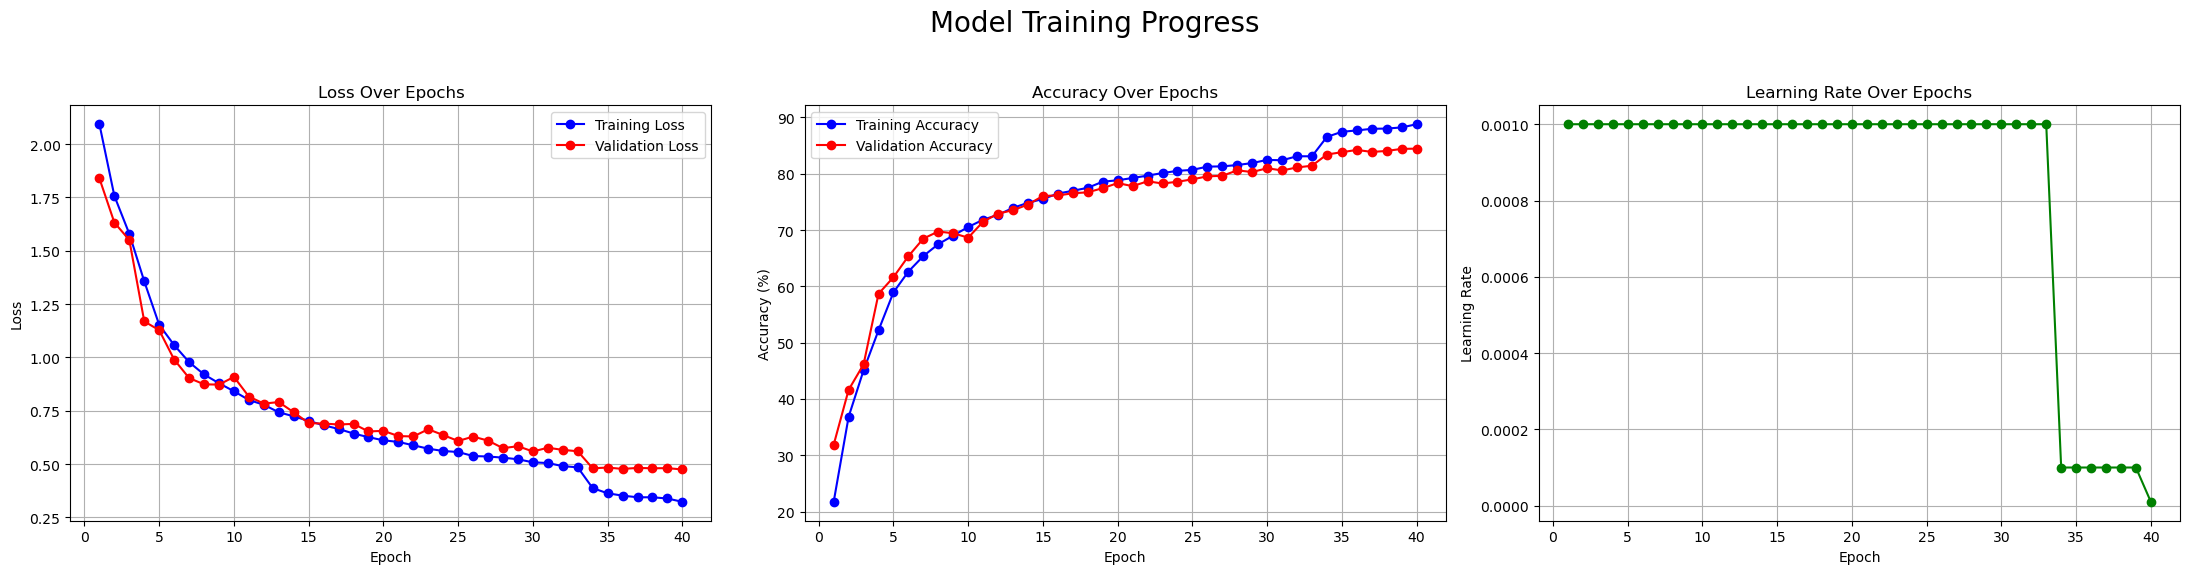

In [15]:
# --- Modified Plotting Function for Per-Epoch LR ---
def plot_metrics_and_lr(history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    ax1.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    # Plot Learning Rate (now per epoch)
    ax3.plot(epochs, history['learning_rate'], 'go-')
    ax3.set_title('Learning Rate Over Epochs')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.grid(True)

    fig.suptitle('Model Training Progress', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Call the updated plotting function ---
plot_metrics_and_lr(history)

**Interpreting the Plots:**

*   **Loss Over Epochs (Left Plot):** This is the classic sign of a healthy training process. Both the training loss (blue) and validation loss (red) decrease steadily and start to converge. Importantly, the validation loss doesn't start to climb, which would be a sign of overfitting.
*   **Accuracy Over Epochs (Middle Plot):** This plot mirrors the loss plot. Both training and validation accuracy climb consistently, reaching a final validation accuracy of over **84%**. The gap between the two curves is small, again indicating that our model is generalizing well.
*   **Learning Rate Over Epochs (Right Plot):** This plot shows our `ReduceLROnPlateau` scheduler in action. The learning rate stays constant for the first ~32 epochs, and then, as the validation loss plateaus, the scheduler drops the LR twice to allow for more precise fine-tuning.

These plots confirm that our SqueezeNet implementation not only works but learns very effectively on the CIFAR-10 dataset.

In [16]:
# 1. Create a new instance of your model architecture
final_model = SqueezeNet()

# 2. Load the saved state dictionary
final_model.load_state_dict(torch.load(SAVE_PATH))

# 3. Move the model to the correct device and set to evaluation mode
final_model.to(device)
final_model.eval()

# Now `final_model` is ready for inference and contains the weights
# from the epoch with the lowest validation loss.
print("Successfully loaded the best model for inference!")

Successfully loaded the best model for inference!


### Step 5: The Final Report Card - Per-Class Accuracy

A single accuracy number can sometimes be misleading. Let's break down the performance for each of the 10 classes in CIFAR-10 to get a more nuanced view.

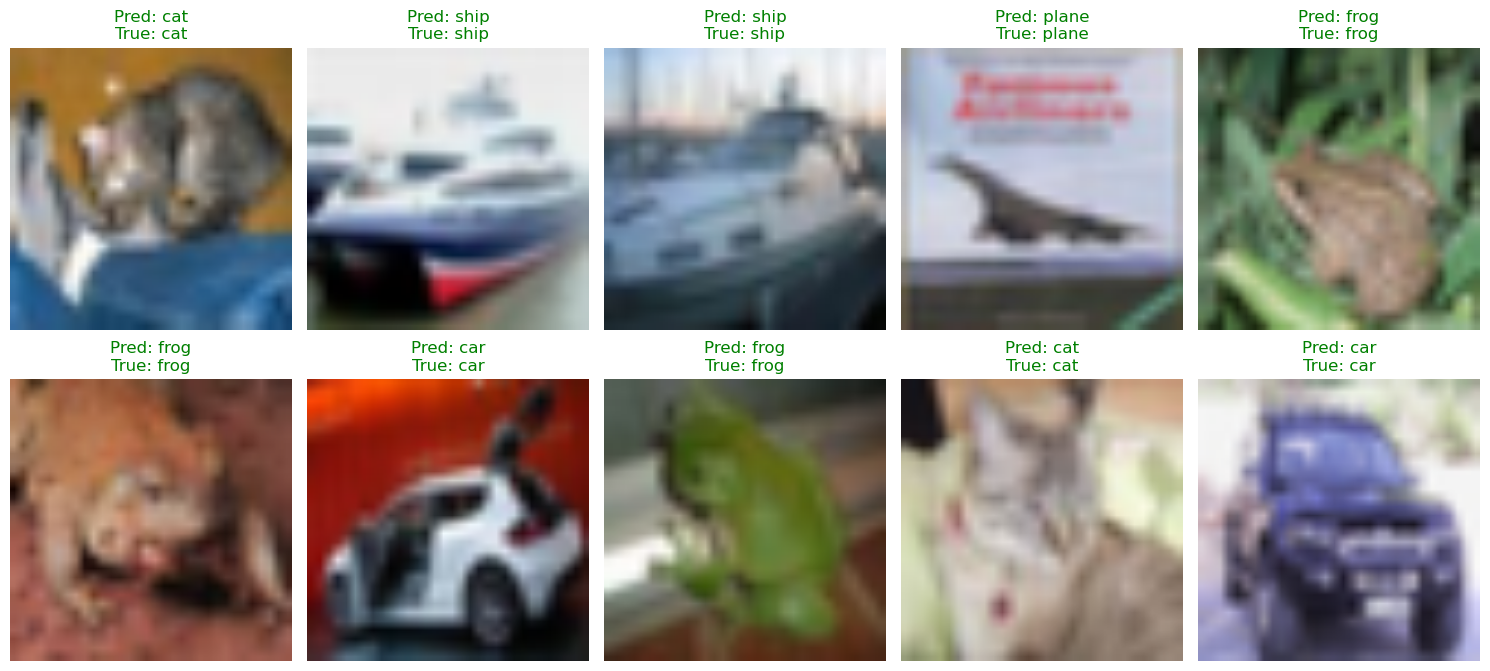

In [ ]:
def visualize_model_predictions(model, dataloader, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 7))

    with torch.no_grad():
        # Get one batch of test images
        dataiter = iter(dataloader)
        images, labels = next(dataiter)

        # Move data to the same device as the model
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(images)
        # Convert outputs to probabilities and then to class predictions
        _, preds = torch.max(outputs, 1)

        # Plot the first `num_images` from the batch
        for i in range(num_images):
            ax = plt.subplot(2, num_images//2, i+1)
            ax.axis('off')

            # Get the predicted and true labels
            pred_label = classes[preds[i]]
            true_label = classes[labels[i]]

            # Set title color based on correctness
            title_color = 'green' if pred_label == true_label else 'red'
            ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=title_color)

            # Un-normalize and display the image
            img = images[i].cpu().numpy().transpose((1, 2, 0))
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            img = std * img + mean
            img = np.clip(img, 0, 1) # Ensure pixel values are valid
            plt.imshow(img)

        model.train(mode=was_training)
        plt.tight_layout()
        plt.show()

# --- Run the Visualization ---
# Use the testloader to get unseen images
visualize_model_predictions(final_model, testloader)

In [ ]:
# Dictionary to store correct predictions for each class
correct_pred = {classname: 0 for classname in classes}
# Dictionary to store total count of each class
total_pred = {classname: 0 for classname in classes}

# --- Iterate Over the Entire Test Dataset ---
with torch.no_grad(): # No need to calculate gradients during evaluation
    for data in tqdm(testloader, desc="Calculating class accuracies"):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = final_model(images)
        _, predictions = torch.max(outputs, 1)

        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

Calculating class accuracies: 100%|██████████| 79/79 [00:11<00:00,  7.09it/s]


In [ ]:
# --- Print Accuracies and Prepare Data for Plotting ---
class_accuracies = []
print("\n" + "="*30)
print("PER-CLASS ACCURACY REPORT")
print("="*30)
for classname, correct_count in correct_pred.items():
    total_count = total_pred[classname]
    accuracy = (100 * float(correct_count) / total_count) if total_count > 0 else 0
    class_accuracies.append(accuracy)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
print("="*30)


PER-CLASS ACCURACY REPORT
Accuracy for class: plane is 89.1 %
Accuracy for class: car   is 92.4 %
Accuracy for class: bird  is 76.8 %
Accuracy for class: cat   is 71.4 %
Accuracy for class: deer  is 82.6 %
Accuracy for class: dog   is 76.5 %
Accuracy for class: frog  is 85.9 %
Accuracy for class: horse is 86.9 %
Accuracy for class: ship  is 90.8 %
Accuracy for class: truck is 92.2 %


/tmp/ipykernel_28907/1062035383.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(classes, rotation=45, ha="right")


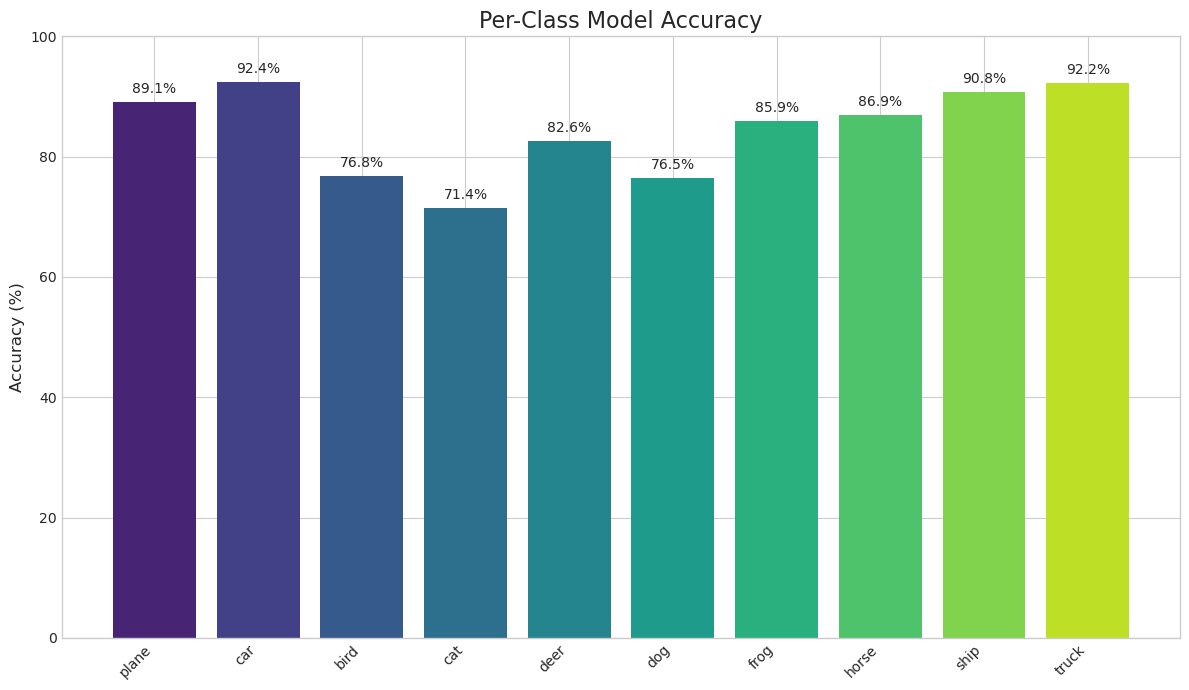

In [ ]:
# --- Create and Display the Bar Chart ---
plt.style.use('seaborn-v0_8-whitegrid') # A nice-looking style
fig, ax = plt.subplots(figsize=(12, 7))

# Create bars
bars = ax.bar(classes, class_accuracies, color=plt.cm.viridis(np.linspace(0.1, 0.9, len(classes))))

# Add labels and title
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Class Model Accuracy', fontsize=16)
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_ylim([0, 100]) # Set y-axis from 0 to 100

# Add the accuracy value on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

This gives us a much clearer picture. We can see that the model is excellent at identifying 'car', 'ship', and 'truck' (all over 90% accuracy), but finds 'cat' a bit more challenging (around 71% accuracy). This is a common result on CIFAR-10 and provides valuable insight into the model's specific strengths and weaknesses.

With training complete and performance thoroughly analyzed, there's only one thing left to do: verify if our model lives up to the "Squeeze" promise of efficiency.

## The Verdict - Did We Fulfill the "Squeeze" Promise?

We've built it, we've trained it, and we've proven that our SqueezeNet implementation is an effective classifier for the CIFAR-10 dataset, achieving over 84% validation accuracy.

But we started this journey with one primary goal in mind, inspired by the SqueezeNet paper: to create a model that is not just accurate, but **radically efficient**. It's time for the moment of truth. Let's measure our final model and see how it stacks up.

### Measuring the Model: Parameters and File Size

There are two key metrics for model efficiency:

1.  **Number of Trainable Parameters:** This is an intrinsic measure of the model's complexity. Fewer parameters generally mean less computation and a lower risk of overfitting.
2.  **File Size on Disk:** This is a practical measure of the model's storage footprint. This is what matters for over-the-air updates and fitting a model into the limited memory of an edge device.

We can easily calculate both of these for our saved PyTorch model.

In [ ]:
# --- Calculate the Number of Trainable Parameters ---

# Use a function to make it reusable and clean
def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(final_model)
print(f"Number of Trainable Parameters: {num_params:,}") # {:,} adds commas for readability

# --- Calculate the File Size on Disk ---

# The size of the saved state_dict file is what we want
# os.path.getsize returns the size in bytes
file_size_bytes = os.path.getsize(SAVE_PATH)
# Convert bytes to megabytes (MB)
file_size_mb = file_size_bytes / (1024 * 1024)

print(f"Model File Size on Disk: {file_size_mb:.2f} MB")

Number of Trainable Parameters: 740,554
Model File Size on Disk: 2.84 MB


Let's pause and appreciate these numbers. Our model, which achieved a very respectable 84% accuracy on a non-trivial dataset, has:

*   **Fewer than 750,000 parameters.**
*   A total file size of **less than 3 megabytes**.

To put this in perspective, the classic VGG-16 model has **138 million parameters** and a file size of over **500 MB**. Our SqueezeNet implementation achieves strong performance while being orders of magnitude more efficient. This is a direct and powerful validation of the design principles laid out in the original paper.

## Pushing the Limits - An Experiment with Batch Size

After achieving these great baseline results, I was curious: could we push the training even further? A common technique to speed up training and potentially improve model performance is to use the largest batch size that your GPU memory can handle. My baseline model was trained with a batch size of 128. I decided to see what would happen if I increased it.

**The Experiment:**

I was using a T4 GPU on Google Colab. My first attempt was to push the batch size to **512**. Unfortunately, this was too ambitious—the session ran out of GPU memory and the kernel crashed. This is a very common and practical limitation that developers face.

My second attempt was to use a more moderate batch size of **384**. This time, the training completed successfully. Here are the results from that run:

::: {layout-ncol=2}
![](images/2025-08-27-squeezenet-implementation/squeezenet-v8-accuracy.png){.lightbox}

![](images/2025-08-27-squeezenet-implementation/squeezenet-v8-training.png){.lightbox}
:::

**Analysis of the Results:**

Interestingly, while the training was faster per epoch, the final model's performance was slightly *lower* than the baseline:

**The Lesson:** While larger batch sizes can speed up training, they don't always guarantee a better final model. There's a complex interplay between batch size, learning rate, and model convergence, and sometimes a smaller batch size can act as a form of regularization, helping the model find a more generalizable solution. It highlights that finding the optimal hyperparameters often requires experimentation and iteration.

## Conclusion: From Theory to Reality

This journey from paper to code has been incredibly rewarding. We've seen firsthand how SqueezeNet's elegant design principles translate into a real, working PyTorch model that is both compact and powerful. The follow-up experiment further reminds us that deep learning is an empirical science, where pushing the limits can reveal fascinating and practical trade-offs.

I encourage you to take this code, experiment with it yourself, and continue exploring the vast and exciting design space of efficient neural networks.